<a href="https://colab.research.google.com/github/choisangh/STUDY/blob/main/finance/RSI_backtrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSI (Relative Strength Index)
* ref : https://secrys.tistory.com/379

* 가격의 상승 압력과 하락 압력 간의 상대적인 강도를 나타내는 지표
* N 기간 동안 주가가 전일 가격 대비 평균 상승량(AU)과 평균 하락량(AD) 비교 (보통 14일 기준)
* RSI는 전체 평균 변화량(AU+AD)에서 평균 상승량(AU)의 비율로 계산됨
* 즉, RSI가 100에 가까울수록 매수세가 강하고 0에 가까울수록 매도세가 강함
* RSI가 100에 가깝다면, 특정 기간 동안 전체 평균 변화량(AU+AD)이 대부분 평균 상승량(AU)이므로 "매수세가 강하다" 라고 판단 가능


<img  width="700" height="" src="https://blog.kakaocdn.net/dn/FoxCn/btrywWx8FwD/rxco4dPoyA6FgQtArZKIIk/img.png">

 * RSI 지표/지수 활용 방법 
- RSI < 30 : 과매도 구간===>매수 시점
- 30 < RSI < 50 : 매도세 우세
- 50 < RSI < 70 : 매수세 우세
- RSI > 70 : 과매수 구간===>매도 시점

## 활용 예

In [ ]:
#pip install pykrx

In [ ]:
import pandas as pd
import datetime as dt
from pykrx import stock
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

### RSI 계산

In [ ]:
def my_rsi(df, period = 14):
  gap = df['Close'].diff(1) #전일 대비 증가/감소분
  gap = gap.dropna() 

  up =  gap.copy()  # 증가/감소 구분하기 위해 카피 
  down = gap.copy() 
  up[up < 0] = 0 #음수값 0으로
  down[down > 0] = 0 #양수값 0으로

#최근 데이터에 더 큰 가중치를 주기위해 AU/AD를 지수이동평균으로 계산
  AU = up.ewm(com=period - 1, adjust=True).mean() 
  AD = abs(down.ewm(com=period - 1, adjust=True).mean()) #변화량이기 때문에 절대값
  RS = AU / AD

  RSI = (RS / (1 + RS)) * 100 #퍼센트 표현 *100
  df['RSI'] = RSI

  return df['RSI']

### OHLCV data load

In [ ]:
start  = "2018-05-04"
end    = "2021-05-10"
ticker = "005930"
# ---------------------------------------
df = stock.get_market_ohlcv(start, end, ticker)
#df = stock.get_market_ohlcv("2021-01-01", "2021-12-31", "005930")
df.columns = ["Open","High","Low","Close","Volume"]
df.head()

,Open,High,Low,Close,Volume
날짜,,,,,
2018-05-04,53000,53900,51800,51900,39565391
2018-05-08,52600,53200,51900,52600,23104720
2018-05-09,52600,52800,50900,50900,16128305
2018-05-10,51700,51700,50600,51600,13905263
2018-05-11,52000,52200,51200,51300,10314997


In [ ]:
df['RSI'] = my_rsi(df)
df.tail()

,Open,High,Low,Close,Volume,RSI
날짜,,,,,,
2021-05-03,81000,82400,81000,81700,15710336,42.202950
2021-05-04,81900,82600,81800,82600,12532550,48.426555
2021-05-06,81700,82300,81700,82300,17047511,46.624317
2021-05-07,81800,82100,81500,81900,14154882,44.259184
2021-05-10,82300,83500,81800,83200,19385027,52.663580


### TA-Lib

* https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
* https://github.com/mrjbq7/ta-lib

In [ ]:
#pip install talib-binary

In [ ]:
import numpy
import talib
from talib.abstract import *

#### RSI
* real = RSI(close, timeperiod=14)


In [ ]:
df['RSI_TA'] = RSI(df['Close'], timeperiod=14)

In [ ]:
df.tail()

,Open,High,Low,Close,Volume,RSI,RSI_TA
날짜,,,,,,,
2021-05-03,81000,82400,81000,81700,15710336,42.202950,42.202950
2021-05-04,81900,82600,81800,82600,12532550,48.426555,48.426555
2021-05-06,81700,82300,81700,82300,17047511,46.624317,46.624317
2021-05-07,81800,82100,81500,81900,14154882,44.259184,44.259184
2021-05-10,82300,83500,81800,83200,19385027,52.663580,52.663580


# RSI 시그널 (RSI Signal)
* ref : https://dungx2.tistory.com/entry/%EC%A3%BC%EC%8B%9D-RSI%EC%9D%98-%EA%B0%9C%EB%85%90
* RSI의 시그널은 RSI의 이동평균선 (보통 9일 기준으로 계산)
* RSI 지표의 일정기간 동안의 과거 평균 수준과 현재를 비교할 수 있는 수치 
* RSI선이 시그널선을 상향 돌파할 때 매수 타이밍 (단기적 매수세 증가) - 골든크로스
* RSI선이 시그널선을 하향 돌파할 때 매도 타이밍 (단기적 매도세 증가) - 데드크로스

<img  width="700" height="" src="https://blog.kakaocdn.net/dn/bkYrkq/btryzB68QKW/uuclLYvpK3smfP1HKsPw90/img.png">

In [ ]:
# TA-Lib 에서는 RSI signal을 구하는 함수가 없음
df['RSI_signal']=df['RSI'].rolling(window=9).mean()
df.tail()

,Open,High,Low,Close,Volume,RSI,RSI_TA,RSI_signal
날짜,,,,,,,,
2021-05-03,81000,82400,81000,81700,15710336,42.202950,42.202950,45.028990
2021-05-04,81900,82600,81800,82600,12532550,48.426555,48.426555,45.327050
2021-05-06,81700,82300,81700,82300,17047511,46.624317,46.624317,45.535384
2021-05-07,81800,82100,81500,81900,14154882,44.259184,44.259184,45.206268
2021-05-10,82300,83500,81800,83200,19385027,52.663580,52.663580,45.354955


In [ ]:
df=df.dropna() #결측제거

## RSI 투자전략
- RSI < 30 (과매도) : 매수
- RSI > 70 (과매수) : 매도

+매수 2018-06-18  46600.00
+매수 2018-10-25  41000.00
+매수 2018-10-26  41000.00
+매수 2018-12-27  38250.00
+매수 2019-01-03  37600.00
+매수 2019-01-04  37450.00
-매도 2019-01-25  44750.00
-매도 2019-01-28  45050.00
-매도 2019-01-29  45500.00
-매도 2019-01-30  46400.00
-매도 2019-01-31  46150.00
-매도 2019-02-01  46350.00
-매도 2019-02-07  46200.00
-매도 2019-02-14  47500.00
+매수 2019-05-09  42450.00
+매수 2019-05-16  41550.00
+매수 2019-05-17  41200.00
-매도 2019-06-28  47000.00
-매도 2019-09-19  49150.00
-매도 2019-09-20  49200.00
-매도 2019-09-23  49300.00
-매도 2019-09-24  49500.00
-매도 2019-09-26  49200.00
-매도 2019-11-05  52700.00
-매도 2019-11-06  53300.00
-매도 2019-12-17  56700.00
-매도 2019-12-18  56300.00
-매도 2020-01-09  58600.00
-매도 2020-01-10  59500.00
-매도 2020-01-13  60000.00
-매도 2020-01-14  60000.00
-매도 2020-01-16  60700.00
-매도 2020-01-17  61300.00
-매도 2020-01-20  62400.00
-매도 2020-01-21  61400.00
-매도 2020-01-22  62300.00
+매수 2020-03-13  49950.00
+매수 2020-03-16  48900.00
+매수 2020-03-17  47300.00
+매수 2020-03-18  45600.00


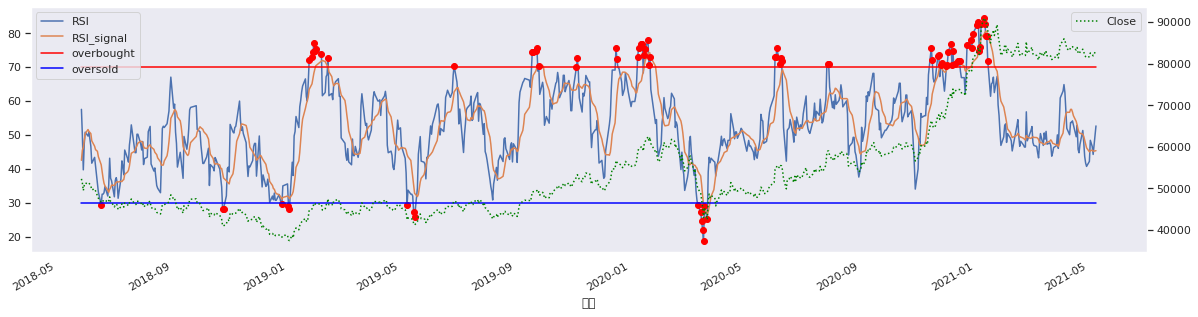

In [ ]:
fig, ax1 = plt.subplots(figsize = (20, 5))

# Slow %K, Slow %D를 그려서 확인
df[['RSI', 'RSI_signal']].plot(ax=ax1)
ax1.grid(False)
# ax.hlines([20,80], df.index.min(), df.index.max(), color ="green", linestyle="--")

for i in range(len(df.index)):
    if df["RSI"].values[i] <= 30 :    #과매도구간 (매수)
        print(f"+매수 {pd.to_datetime(df.index.values[i]).strftime('%Y-%m-%d')}  {df['Close'].values[i]:.2f}")
        ax1.plot(df.index.values[i], df['RSI'].values[i], 'o',color='red')
    elif df["RSI"].values[i] >= 70 :  #과매수구간 (매도)
        print(f"-매도 {pd.to_datetime(df.index.values[i]).strftime('%Y-%m-%d')}  {df['Close'].values[i]:.2f}")
        ax1.plot(df.index.values[i], df['RSI'].values[i], 'o',color='red')    
ax1.plot(df.index, [70] * len(df.index), label="overbought",color='red')
ax1.plot(df.index, [30] * len(df.index), label="oversold",color='blue')
ax2 = ax1.twinx()
df['Close'].plot(ax=ax2,  color='green', linestyle='dotted')
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend()

plt.show()

##RSI + RSI Signal 투자전략
- RSI < 30(과매도) & 시그널 골든크로스 : 매수
- RSI > 70(과매수) & 시그널 데드크로스 : 매도

-매도 2019-09-26  49200.00
-매도 2020-01-21  61400.00
-매도 2020-01-22  62300.00
+매수 2020-03-20  45400.00
-매도 2020-12-11  73400.00
-매도 2020-12-14  73800.00
-매도 2020-12-15  73800.00
-매도 2020-12-16  73800.00
-매도 2021-01-06  82200.00
-매도 2021-01-07  82900.00
-매도 2021-01-13  89700.00
-매도 2021-01-14  89700.00
-매도 2021-01-15  88000.00


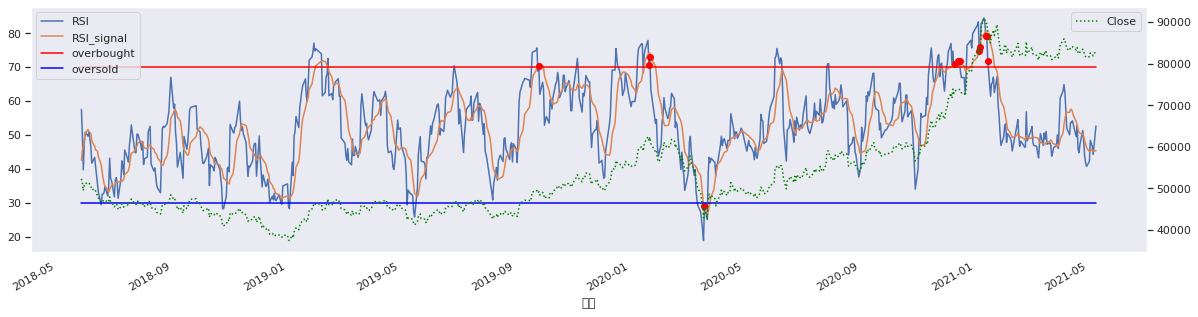

In [ ]:
fig, ax1 = plt.subplots(figsize = (20, 5))

# Slow %K, Slow %D를 그려서 확인
df[['RSI', 'RSI_signal']].plot(ax=ax1)
ax1.grid(False)
# ax.hlines([20,80], df.index.min(), df.index.max(), color ="green", linestyle="--")

for i in range(len(df.index)):
    if df["RSI"].values[i] <= 30 and (df["RSI"].values[i] > df["RSI_signal"].values[i]) :    #콜든크로스(매수)
        print(f"+매수 {pd.to_datetime(df.index.values[i]).strftime('%Y-%m-%d')}  {df['Close'].values[i]:.2f}")
        ax1.plot(df.index.values[i], df['RSI'].values[i], 'o',color='red')
    elif df["RSI"].values[i] >= 70 and (df["RSI"].values[i] < df["RSI_signal"].values[i]) :  #데드크로스(매도)
        print(f"-매도 {pd.to_datetime(df.index.values[i]).strftime('%Y-%m-%d')}  {df['Close'].values[i]:.2f}")
        ax1.plot(df.index.values[i], df['RSI'].values[i], 'o',color='red')    
ax1.plot(df.index, [70] * len(df.index), label="overbought",color='red')
ax1.plot(df.index, [30] * len(df.index), label="oversold",color='blue')
ax2 = ax1.twinx()
df['Close'].plot(ax=ax2,  color='green', linestyle='dotted')
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend()

plt.show()

# 백테스팅

In [ ]:
#pip install backtrader

##RSI 투자전략
- RSI < 30 (과매도) : 매수
- RSI > 70 (과매수) : 매도

In [ ]:
import backtrader as bt
from pykrx import stock
import pandas as pd


"""
다음과 같은 에러 발생
        ImportError: cannot import name 'warnings' from 'matplotlib.dates' (C:\AI\pythonProject\venv\lib\site-packages\matplotlib\dates.py)
해결책  : 현재  matplotlib 3.5.1  --> 3.2.2로 버전 다운
        pip install -U matplotlib==3.2.2 
"""


# 볼린저밴드 : 20일 이동평균선을 기준으로 주가가 어느 위치에 있는지 알려주는 지표
# 상단선: 20일 이동평균선 + 2 * 표준편차
# 하단선: 20일 이동평균선 - 2 * 표준편차

class RSI(bt.Strategy): # bt.Strategy를 상속한 class로 생성해야 함.

    def log(self, txt, dt=None): # 기록 함수
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
                dt = bt.num2date(dt)
                print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self): # 생성자 함수 #볼린저밴드
        self.rsi = bt.indicators.RSI(self.data.close, period=14)
        self.rsi_signal = bt.indicators.SimpleMovingAverage(self.rsi, period=9)

    # https://jsp-dev.tistory.com/entry/PythonBacktrader-%EB%8B%A4%EC%A4%91-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8C%85-Python-sqlite3backtrader-Mutliple-Data-Feeds-Pandas-DataFrame-to-Backtrader
    def next(self):  #전략 함수
        global size
        if not self.position: # not in the market # 포지션이 없으면(매수/매도가 없음)
            if (self.rsi <= 30) : 
                size = int(self.broker.getcash() / self.data.close[0])
                # 최대 구매 가능 개수
                self.buy(price=self.data.close[0], size=size) #매수
                # 매수 size = 구매 개수 설정
                self.log('BUY CREATE, %.2f' % (self.data.close[0]))
                print(size, 'EA')
        else: #포지션이 있는 경우
            if (self.rsi >= 70): 
                self.sell(price=self.data.close[0],size=size)
                # 매도
                self.log('SELL CREATE, %.2f' % (self.data.close[0]))
                print(size, 'EA')
#--------------------------------------------------------------------

size=0
ticker =  "005930"
# 전체 종목코드와 종목명 가져오기
# df = df.rename(columns={'시가':'open', '고가':'high', '저가':'low', '종가':'close', '거래량':'volume'})
# df["open"]=df["open"].apply(pd.to_numeric,errors="coerce")

from pykrx import stock
df = stock.get_market_ohlcv("2018-04-28", "2021-05-10", ticker)
df.columns = ["open","high","low","close","volume"]

data = bt.feeds.PandasData(dataname=df) #데이터 넣어주기
cerebro = bt.Cerebro() #백테스팅 총괄자 class

startcash=1000000
cerebro.broker.setcash(startcash)             #------------------- 투자금액 설정
cerebro.broker.setcommission(0.00015)       #------------------- 0.015% 수수료

for idx, ticker in enumerate(['005930']): #for문으로 기업 데이터 input
    cerebro.adddata(data, name=ticker)                       #------------------- Add the data feed


cerebro.addstrategy(RSI)               #------------------- Add the trading strategy

start_value = cerebro.broker.getvalue()
cerebro.run()  # run it all
final_value = cerebro.broker.getvalue()

print('* start value : {} won'.format(start_value))
print('* final value : {} won'.format(final_value))
print('* earning rate : {}%'.format(round((final_value - start_value) / start_value * 100.0,3)))




2018-06-18T00:00:00, BUY CREATE, 46600.00
21 EA
2019-01-25T00:00:00, SELL CREATE, 44750.00
21 EA
2019-05-09T00:00:00, BUY CREATE, 42450.00
22 EA
2019-06-28T00:00:00, SELL CREATE, 47000.00
22 EA
2020-03-13T00:00:00, BUY CREATE, 49950.00
21 EA
2020-06-03T00:00:00, SELL CREATE, 54500.00
21 EA
* start value : 1000000 won
* final value : 1177079.1500000001 won
* earning rate : 17.708%


##RSI + RSI Signal 투자전략
- RSI < 30(과매도) & 시그널 골든크로스 : 매수
- RSI > 70(과매수) & 시그널 데드크로스 : 매도

In [ ]:
import backtrader as bt
from pykrx import stock
import pandas as pd


"""
다음과 같은 에러 발생
        ImportError: cannot import name 'warnings' from 'matplotlib.dates' (C:\AI\pythonProject\venv\lib\site-packages\matplotlib\dates.py)
해결책  : 현재  matplotlib 3.5.1  --> 3.2.2로 버전 다운
        pip install -U matplotlib==3.2.2 
"""


# 볼린저밴드 : 20일 이동평균선을 기준으로 주가가 어느 위치에 있는지 알려주는 지표
# 상단선: 20일 이동평균선 + 2 * 표준편차
# 하단선: 20일 이동평균선 - 2 * 표준편차

class RSI(bt.Strategy): # bt.Strategy를 상속한 class로 생성해야 함.

    def log(self, txt, dt=None): # 기록 함수
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
                dt = bt.num2date(dt)
                print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self): # 생성자 함수 #볼린저밴드
        self.rsi = bt.indicators.RSI(self.data.close, period=14)
        self.rsi_signal = bt.indicators.SimpleMovingAverage(self.rsi, period=9)

    # https://jsp-dev.tistory.com/entry/PythonBacktrader-%EB%8B%A4%EC%A4%91-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8C%85-Python-sqlite3backtrader-Mutliple-Data-Feeds-Pandas-DataFrame-to-Backtrader
    def next(self):  #전략 함수
        global size
        if not self.position: # not in the market # 포지션이 없으면(매수/매도가 없음)
            if (self.rsi <= 30) and (self.rsi > self.rsi_signal) : 
                size = int(self.broker.getcash() / self.data.close[0])
                # 최대 구매 가능 개수
                self.buy(price=self.data.close[0], size=size) #매수
                # 매수 size = 구매 개수 설정
                self.log('BUY CREATE, %.2f' % (self.data.close[0]))
                print(size, 'EA')
        else: #포지션이 있는 경우
            if (self.rsi >= 70) and (self.rsi < self.rsi_signal): 
                self.sell(price=self.data.close[0],size=size)
                # 매도
                self.log('SELL CREATE, %.2f' % (self.data.close[0]))
                print(size, 'EA')
#--------------------------------------------------------------------

size=0
ticker =  "005930"
# 전체 종목코드와 종목명 가져오기
# df = df.rename(columns={'시가':'open', '고가':'high', '저가':'low', '종가':'close', '거래량':'volume'})
# df["open"]=df["open"].apply(pd.to_numeric,errors="coerce")

from pykrx import stock
df = stock.get_market_ohlcv("2018-04-28", "2021-05-10", ticker)
df.columns = ["open","high","low","close","volume"]

data = bt.feeds.PandasData(dataname=df) #데이터 넣어주기
cerebro = bt.Cerebro() #백테스팅 총괄자 class

startcash=1000000
cerebro.broker.setcash(startcash)             #------------------- 투자금액 설정
cerebro.broker.setcommission(0.00015)       #------------------- 0.015% 수수료

for idx, ticker in enumerate(['005930']): #for문으로 기업 데이터 input
    cerebro.adddata(data, name=ticker)                       #------------------- Add the data feed


cerebro.addstrategy(RSI)               #------------------- Add the trading strategy

start_value = cerebro.broker.getvalue()
cerebro.run()  # run it all
final_value = cerebro.broker.getvalue()

print('* start value : {} won'.format(start_value))
print('* final value : {} won'.format(final_value))
print('* earning rate : {}%'.format(round((final_value - start_value) / start_value * 100.0,3)))




2020-03-20T00:00:00, BUY CREATE, 45400.00
22 EA
2020-12-11T00:00:00, SELL CREATE, 73400.00
22 EA
* start value : 1000000 won
* final value : 1681616.54 won
* earning rate : 68.162%


# 제언

* 삼성전자는 같은 대형 우량주는 과매도&골든크로스 구간이 상대적으로 적음 (3년간 1번) -> 확실한 매수 타이밍으로 볼 수 있을 듯 
* RSI + RSI Signal 투자 전략이 수익률이 훨씬 좋음 :
    - RSI만 활용한 투자전략은 과매도/매수 구간에 들어가기만 하면 곧바로 매매 (심지어 과매도 구간이 적어서 수익률이 크지 않음)
    - 시그널까지 고려한 투자전략은 과매도/매수 구간 이후 어느정도 기간을 갖고 매매타이밍을 기다리기 때문에 수익률이 높아보임